In [2]:
library(XML)
library(sets)
library(repr)
library(gtools)
library(stringr)
library(R.matlab)
library(foreach)
library(doParallel)

#### Setup Ripser

In [3]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/dbhaskar92/ripser/ripser", 
                        args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), 
                        stdout = TRUE)
    
    return( parseOutput( ripserOut ) )
}

#### Get list of simulations from remote file server

In [4]:
url = "http://167.99.155.161:8000/MRC/Data/swarm_simulations/"
doc = htmlParse(url)
links = xpathSApply(doc, "//a/@href")
sim_dirs = vector("list")
for (i in seq(1, length(links))){
    remote_item = unname(links[i])
    if (str_sub(remote_item,start=-1) == .Platform$file.sep){
           sim_dirs[i] = remote_item
    }
}
paste(sim_dirs)

[1] "data_icR_1_ilR_1/" "data_icR_1_ilR_2/" "data_icR_1_ilR_3/"
 [4] "data_icR_1_ilR_4/" "data_icR_1_ilR_5/" "data_icR_2_ilR_1/"
 [7] "data_icR_2_ilR_2/" "data_icR_2_ilR_3/" "data_icR_2_ilR_4/"
[10] "data_icR_2_ilR_5/" "data_icR_3_ilR_1/" "data_icR_3_ilR_2/"
[13] "data_icR_3_ilR_3/" "data_icR_3_ilR_4/" "data_icR_3_ilR_5/"
[16] "data_icR_4_ilR_1/" "data_icR_4_ilR_2/" "data_icR_4_ilR_3/"
[19] "data_icR_4_ilR_4/" "data_icR_4_ilR_5/" "data_icR_5_ilR_1/"
[22] "data_icR_5_ilR_2/" "data_icR_5_ilR_3/" "data_icR_5_ilR_4/"
[25] "data_icR_5_ilR_5/"

#### Store (icR, ilR) parameter values for simulations of interest 

In [5]:
double_ring = list(list(1,1), list(2,2), list(3,3))
single_mill = list(list(2,1), list(3,1), list(4,1))
collective_swarm = list(list(1,4), list(2,4), list(3,4))
stored_sims = c(double_ring, single_mill, collective_swarm)
paste(stored_sims)

[1] "list(1, 1)" "list(2, 2)" "list(3, 3)" "list(2, 1)" "list(3, 1)"
[6] "list(4, 1)" "list(1, 4)" "list(2, 4)" "list(3, 4)"

#### Read MAT file stored on the fileserver over the network

In [6]:
remote_mat_read <- function(r_url){
    
    mat_data = readMat(r_url)
    N = mat_data$N            # number of particle, 200
    alpha = mat_data$alpha    # fixed param, 1.5 
    beta = mat_data$beta      # fixed param, 0.5
    cA = mat_data$cA          # fixed param, 1.0
    cR = mat_data$cR
    iR = mat_data$iR
    lA = mat_data$lA          # fixed param, 1.0
    lR = mat_data$lR
    tseries = mat_data$t
    sim_data = mat_data$z
    tpoints = length(tseries) # number of timesteps, 2001
    
    if (length(sim_data) == tpoints * 4 * N){
        xpos = matrix(nrow = N, ncol = tpoints)
        ypos = matrix(nrow = N, ncol = tpoints)
        xvel = matrix(nrow = N, ncol = tpoints)
        yvel = matrix(nrow = N, ncol = tpoints)
        for (itr in seq(1, length(tseries))){
            xpos[,itr] = sim_data[itr, 1:N]
            ypos[,itr] = sim_data[itr, (N+1):(2*N)]
            xvel[,itr] = sim_data[itr, (2*N+1):(3*N)]
            yvel[,itr] = sim_data[itr, (3*N+1):(4*N)]
        }
        return(list("N" = N, "cR" = cR, "lR" = lR, "iR" = iR,
                   "xpos" = xpos, "ypos" = ypos, "xvel" = xvel, "yvel" = yvel))
    } else {
        print("ERROR: Unexpected file size.")
        return(NULL)
    }
    
}

#### Get simulation data given parameter values

In [7]:
obtain_sim_url <- function(icR, ilR, iR){
    
    sep = .Platform$file.sep
    sim_folder = paste('data_icR_', icR, '_ilR_', ilR, sep="")
    mat_file = paste('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '.mat', sep="")
    return(paste(url, sim_folder, sep, mat_file, sep=""))
    
}

#### Plot simulation

In [8]:
plot_sim <- function(xpos, ypos, tpoint){
    
    options(repr.plot.width=5, repr.plot.height=5)
    plot(xpos[,tpoint], ypos[,tpoint], xlab="X", ylab="Y")
    
}

#### Get max and min position of all simulations over all time points
**Warning:** Serial computation - *very slow*

In [9]:
max_pos = 0
min_pos = 0

for (sim in sim_dirs){
    
    icR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[3]))
    ilR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[5]))
    
    if (any(sapply(stored_sims, identical, list(icR, ilR)))){
        
        # get list of mat files (for all realizations) for each simulation parameter
        
        remote_folder = paste(url, sim, sep="")
        doc = htmlParse(remote_folder)
        links = xpathSApply(doc, "//a/@href")
        sim_files = vector("list")
        for (i in seq(1, length(links))){
            remote_item = unname(links[i])
            if (str_sub(remote_item,start=-4) == ".mat"){
                sim_files[i] = remote_item
            }
        }
        sim_files = mixedsort(paste(sim_files))
        
        cat(paste("Found", length(sim_files), "simulation files in", sim, "\n"))
        
        # for the first 25 realizations/replicates

        for (replicate in sim_files[1:25]){

            mat_url = paste(remote_folder, replicate, sep="")
            sim_data = remote_mat_read(mat_url)

            # compute max and min position
            max_sim_pos = max(max(sim_data$xpos), max(sim_data$ypos))
            min_sim_pos = min(min(sim_data$xpos), min(sim_data$ypos))
            if (max_sim_pos > max_pos){
                max_pos = max_sim_pos 
            }
            if (min_sim_pos < min_pos){
                min_pos = min_sim_pos
            }
            
        }
            
    }
       
}

print(c("Max. position found: ", max_pos))
print(c("Min. position found: ", min_pos))

Found 100 simulation files in data_icR_1_ilR_1/ 
Found 100 simulation files in data_icR_1_ilR_4/ 
Found 100 simulation files in data_icR_2_ilR_1/ 
Found 100 simulation files in data_icR_2_ilR_2/ 
Found 100 simulation files in data_icR_2_ilR_4/ 
Found 100 simulation files in data_icR_3_ilR_1/ 
Found 100 simulation files in data_icR_3_ilR_3/ 
Found 100 simulation files in data_icR_3_ilR_4/ 
Found 100 simulation files in data_icR_4_ilR_1/ 
[1] "Max. position found: " "1.5349801787012"      
[1] "Min. position found: " "-1.48421104003908"    


#### In parallel, normalize simulation data and compute Crocker plots

In [9]:
cores = detectCores()
cl = makeCluster(cores[1]-2)
registerDoParallel(cl)
cat(c("Number of cores:",cores))

Number of cores: 12

In [10]:
max_pos = 12
min_pos = -12

for (sim in sim_dirs){
    
    icR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[3]))
    ilR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[5]))
    
    if (any(sapply(stored_sims, identical, list(icR, ilR)))){
        
        cat(c("Processing:", sim, "\n"))
        
        # get list of mat files (for all realizations) for each simulation parameter
        
        remote_folder = paste(url, sim, sep="")
        doc = htmlParse(remote_folder)
        links = xpathSApply(doc, "//a/@href")
        sim_files = vector("list")
        for (i in seq(1, length(links))){
            remote_item = unname(links[i])
            if (str_sub(remote_item,start=-4) == ".mat"){
                sim_files[i] = remote_item
            }
        }
        sim_files = mixedsort(paste(sim_files))
        
        # for the first 5 realizations/replicates

        out <- foreach(j=1:5, .combine=cbind, .packages='R.matlab') %dopar% {

            replicate = sim_files[j]
            mat_url = paste(remote_folder, replicate, sep="")
            sim_data = remote_mat_read(mat_url)
            
            fname = paste('/home/dbhaskar92/anaconda2/notebook-server/MRC/', 
                          'data_icR_', icR, '_ilR_', ilR, '_iR_', j, '_CD_pos.csv', sep="")
            
            # normalize
            sim_data$xpos = (sim_data$xpos - min_pos)/(max_pos - min_pos)
            sim_data$ypos = (sim_data$ypos - min_pos)/(max_pos - min_pos)
            
            N = dim(sim_data$xpos)[1]
            ntpoints = dim(sim_data$xpos)[2]
            
            # for every 23rd time point (87 total time points)
            tsteps = seq(1, ntpoints, by=23)
            ntsteps = length(tsteps)
            
            # delta(eps) = 1e-4
            eps_vals = seq(0, 1, by=0.0001)
            num_eps = length(eps_vals)
            
            dim0Crocker = vector(mode = "list", length = ntsteps*num_eps)
            dim1Crocker = vector(mode = "list", length = ntsteps*num_eps)
            
            k = 0
            
            for (tp in tsteps){
                
                xdata = sim_data$xpos[,tp]
                ydata = sim_data$ypos[,tp]

                # compute persistence homology using ripser
                homology <- ripserDiag(cbind(xdata, ydata), 1, 5)
                intervals = as.data.frame(homology)
                dim0 = intervals[intervals$dimension==0,]
                dim1 = intervals[intervals$dimension==1,]

                num_feats_dim0 = dim(dim0)[1]
                num_feats_dim1 = dim(dim1)[1]

                # compute CROCKER plot
                for (eps in eps_vals){
        
                    betti0 = sum((dim0$Birth < eps) & (dim0$Death > eps))
                    betti1 = sum((dim1$Birth < eps) & (dim1$Death > eps))
                    
                    k = k + 1
                    dim0Crocker[k] = toString(c(k, tp, 0, eps, betti0))
                    dim1Crocker[k] = toString(c(ntsteps*num_eps + k, tp, 1, eps, betti1))

                }

            }
            
            # write CROCKER data to file
            sink(fname)
            cat(as.character(c(dim0Crocker, dim1Crocker)), sep='\n')
            sink()
            
            return(replicate)
            
        }
        
        cat(c(out, "\n"))
        cat("\n")
    }
       
}

In [11]:
stopCluster(cl)

#### Example: Generate CROCKER plot for one simulation

In [12]:
mat_url = obtain_sim_url(1, 4, 50)
sim_data = remote_mat_read(mat_url)
str(sim_data)

List of 8
 $ N   : num [1, 1] 200
 $ cR  : num [1, 1] 0.1
 $ lR  : num [1, 1] 2
 $ iR  : num [1, 1] 50
 $ xpos: num [1:200, 1:2001] -0.855 -0.0959 0.2168 0.7301 0.7721 ...
 $ ypos: num [1:200, 1:2001] -0.755 0.952 -0.524 -0.819 0.132 ...
 $ xvel: num [1:200, 1:2001] -0.7016 -0.8119 0.6036 -0.0971 0.869 ...
 $ yvel: num [1:200, 1:2001] -0.29465 -0.72314 0.37137 0.00771 0.46819 ...


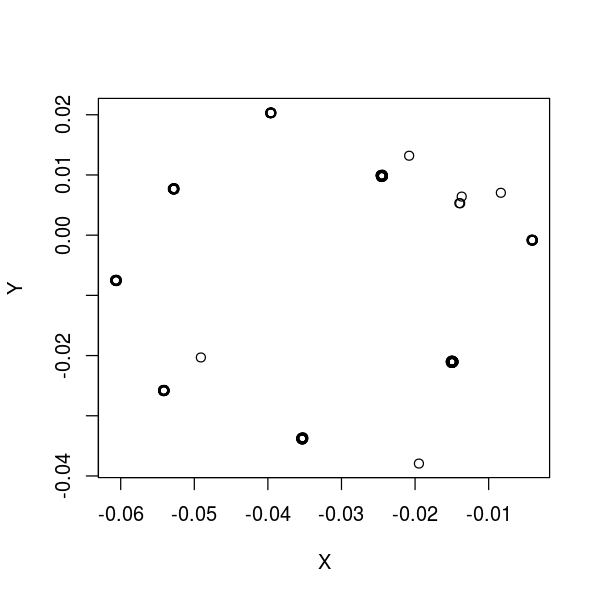

In [13]:
plot_sim(sim_data$xpos, sim_data$ypos, 2001)

In [14]:
sim_data$xpos = (sim_data$xpos - min_pos)/(max_pos - min_pos)
sim_data$ypos = (sim_data$ypos - min_pos)/(max_pos - min_pos)

In [15]:
N = dim(sim_data$xpos)[1]
ntpoints = dim(sim_data$xpos)[2]

In [18]:
tsteps = seq(1, ntpoints, by=23)  # 2001/3 = 667 time points, 2001/23 = 87 time points
ntsteps = length(tsteps)

eps_vals = seq(0, 1, by=0.0001)   # 1/0.0008 = 1250 eps values, 1/0.0002 = 5000 eps values   
num_eps = length(eps_vals)

dim0Crocker = vector(mode = "list", length = ntsteps*num_eps)
dim1Crocker = vector(mode = "list", length = ntsteps*num_eps)
orderparams = vector(mode = "list", length = ntsteps)

i = 0
k = 0

for (tp in tsteps){                     
    
    xdata = sim_data$xpos[,tp]
    ydata = sim_data$ypos[,tp]
    xv = sim_data$xvel[,tp]
    yv = sim_data$yvel[,tp]
    
    # run ripser
    homology <- ripserDiag(cbind(xdata, ydata), 1, 2)
    intervals = as.data.frame(homology)
    dim0 = intervals[intervals$dimension==0,]
    dim1 = intervals[intervals$dimension==1,]
    
    num_feats_dim0 = dim(dim0)[1]
    num_feats_dim1 = dim(dim1)[1]
    
    # compute CROCKER plot
    for (eps in eps_vals){
        
        betti0 = sum((dim0$Birth < eps) & (dim0$Death > eps))
        betti1 = sum((dim1$Birth < eps) & (dim1$Death > eps))
        
        i = i + 1
        dim0Crocker[i] = toString(c(i, tp, 0, eps, betti0))
        dim1Crocker[i] = toString(c(ntsteps*num_eps + i, tp, 1, eps, betti1))
        
    }
    
    # compute order params
    
    # norm of the velocity
    v_norm = sqrt(xv^2 + yv^2)
    
    # center of mass
    c_x = mean(xdata)
    c_y = mean(ydata)
      
    # mean centered positions
    r_x = xdata - c_x
    r_y = ydata - c_y      
    r_norm <- sqrt(r_x^2 + r_y^2)
    
    # cross product
    rvcross = r_x*yv - r_y*xv

    # polarization vector
    P = sqrt((sum(xv)/sum(v_norm))^2 + (sum(yv)/sum(v_norm))^2)

    # angular momentum
    Mang = abs(sum(rvcross)/sum(v_norm*r_norm))

    # absolute angular momentum
    Mabs = abs(sum(abs(rvcross))/sum(v_norm*r_norm))
    
    # distance matrices in x,y
    Xdiff = as.matrix(dist(xdata))
    Ydiff = as.matrix(dist(ydata))
        
    # total distance matrices in R^2
    D = sqrt(Xdiff^2 + Ydiff^2)
    # remove zeros
    for (j in seq(1, length(D), nrow(D)+1)){
        D[j] = Inf
    }
    
    # sum mins from each row
    min_sum = 0
    for (j in 1:N) {
        min_sum = min_sum + min(D[j,])
    }
    nnd = min_sum/N
    
    k = k + 1
    orderparams[k] = toString(c(tp, P, Mang, Mabs, nnd))
    
}

cat("Expected: total number of rows = # time points * # eps values = 87 * 10001 = 870087\n")
cat(c("Got: ", i))

Expected: total number of rows = # time points * # eps values = 87 * 10001 = 870087
Got:  870087

In [19]:
fileConn = file("data_icR_1_ilR_4_iR_50_CD_pos.csv")
writeLines(as.character(c(dim0Crocker, dim1Crocker)), fileConn)
close(fileConn)

In [20]:
fileConn = file("data_icR_1_ilR_4_iR_50_order_params.csv")
writeLines(as.character(orderparams), fileConn)
close(fileConn)